In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Exploração inicial:

In [72]:
df = pd.read_csv("../databases/tratado/consumo residencial por UF/consumo residencial bahia.csv",index_col=0)

In [73]:
df.head(5)

,consumo
data,
31/01/2004,294.798
29/02/2004,269.980
31/03/2004,276.717
30/04/2004,290.815
31/05/2004,282.304


In [74]:
df.tail(5)

,consumo
data,
31/08/2023,612.484
30/09/2023,655.231
31/10/2023,661.873
30/11/2023,703.405
31/12/2023,718.461


In [75]:
df.describe()

,consumo
count,240.000000
mean,488.621675
std,129.586803
min,247.536000
25%,368.417000
50%,514.150000
75%,594.730500
max,718.461000


In [76]:
#Converter o tipo do indice para data
df.index = pd.to_datetime(df.index, format="%d/%m/%Y")

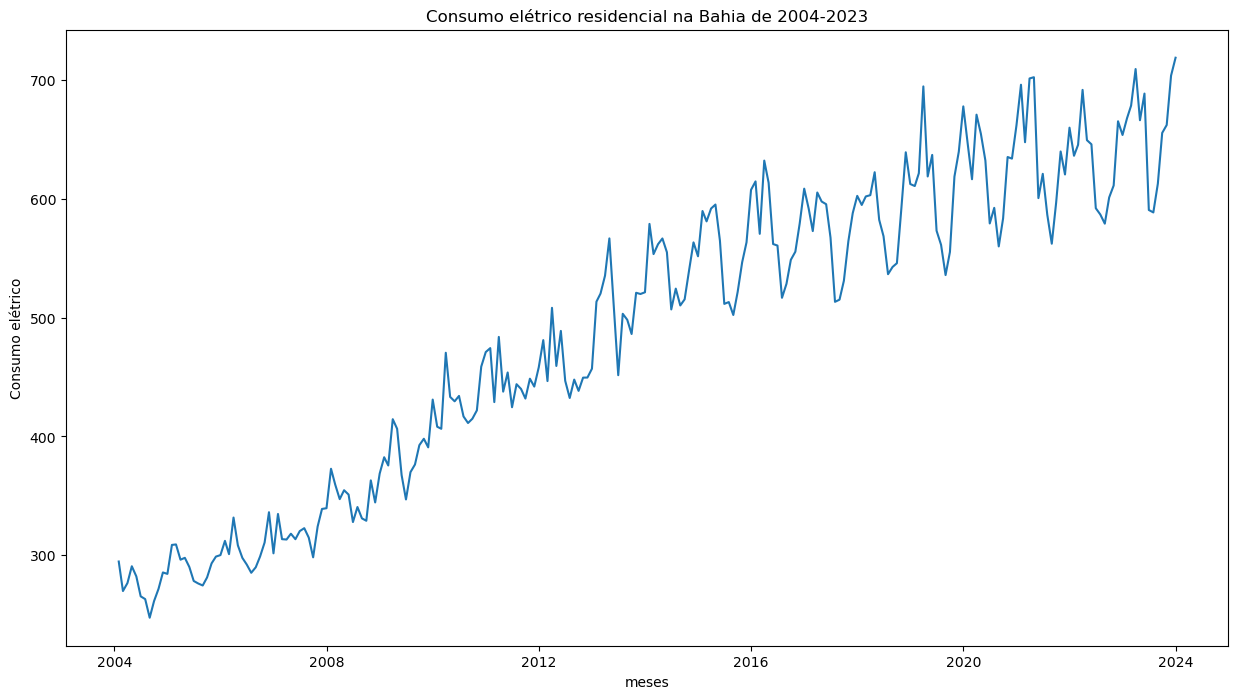

In [77]:
plt.figure(figsize=(15,8))
plt.plot(df.index, df["consumo"], label="Consumo elétrico mensal residencial na Bahia, 2004-2023")
plt.ylabel("Consumo elétrico")
plt.xlabel("meses")
plt.title("Consumo elétrico residencial na Bahia de 2004-2023")
plt.show()

Previsão

In [78]:
#Separando em treino e teste
TREINO_PROPORCAO = .8
tamanho = len(df)
treino_df=df.iloc[:int(tamanho * TREINO_PROPORCAO)].copy()
teste_df = df.iloc[int(tamanho * TREINO_PROPORCAO):].copy()

In [179]:
#Quantos para treino e teste?
print("Para treino", treino_df.shape[0])
print("Para teste",teste_df.shape[0])

Para treino 192
Para teste 48


In [79]:
from sklearn.preprocessing import MinMaxScaler
escalador = MinMaxScaler()
treino_escalado = escalador.fit_transform(treino_df)
teste_escalado = escalador.transform(teste_df)

In [80]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [181]:
TIME_STEPS = 5
X_train, y_train = create_dataset(treino_escalado, treino_escalado, TIME_STEPS)
X_test, y_test = create_dataset(teste_escalado, teste_escalado, TIME_STEPS)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(187, 5, 1) (187, 1)
(43, 5, 1) (43, 1)


In [111]:
from sklearn.svm import SVR

modelo = SVR(kernel="rbf", gamma=0.5, epsilon=0.05)

In [112]:
modelo.fit(X_train.reshape(X_train.shape[0], -1), y_train)

SVR(epsilon=0.05, gamma=0.5)

In [114]:
treino_previsao = modelo.predict(X_train.reshape(X_train.shape[0], -1))
teste_previsao = modelo.predict(X_test.reshape(X_test.shape[0], -1))

Realisando as inversões

In [116]:
treino_previsao_inv = escalador.inverse_transform(treino_previsao.reshape(-1, 1))
y_train_inv = escalador.inverse_transform(y_train.reshape(-1, 1))
teste_previsao_inv = escalador.inverse_transform(teste_previsao.reshape(-1, 1))
y_test_inv = escalador.inverse_transform(y_test.reshape(-1, 1))

Checando a eficiência

In [121]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [122]:
mse_treino = mean_squared_error(y_train_inv, treino_previsao_inv)
mse_teste = mean_squared_error(y_test_inv, teste_previsao_inv)

In [124]:
print("Mean Squared Error (treino)",mse_treino, sep=" ")
print("Mean Squared Error (teste)",mse_teste, sep=" ")

Mean Squared Error (treino) 619.4183260606599
Mean Squared Error (teste) 2319.2918040463614


In [123]:
mae_treino = mean_absolute_error(y_train_inv, treino_previsao_inv)
mae_teste = mean_absolute_error(y_test_inv, teste_previsao_inv)

In [125]:
print("Mean Absolute Error (treino)",mae_treino, sep=" ")
print("Mean Absolute Error (teste)",mae_teste, sep=" ")

Mean Absolute Error (treino) 18.733616198175213
Mean Absolute Error (teste) 40.34741681654892


Plotando os resultados:

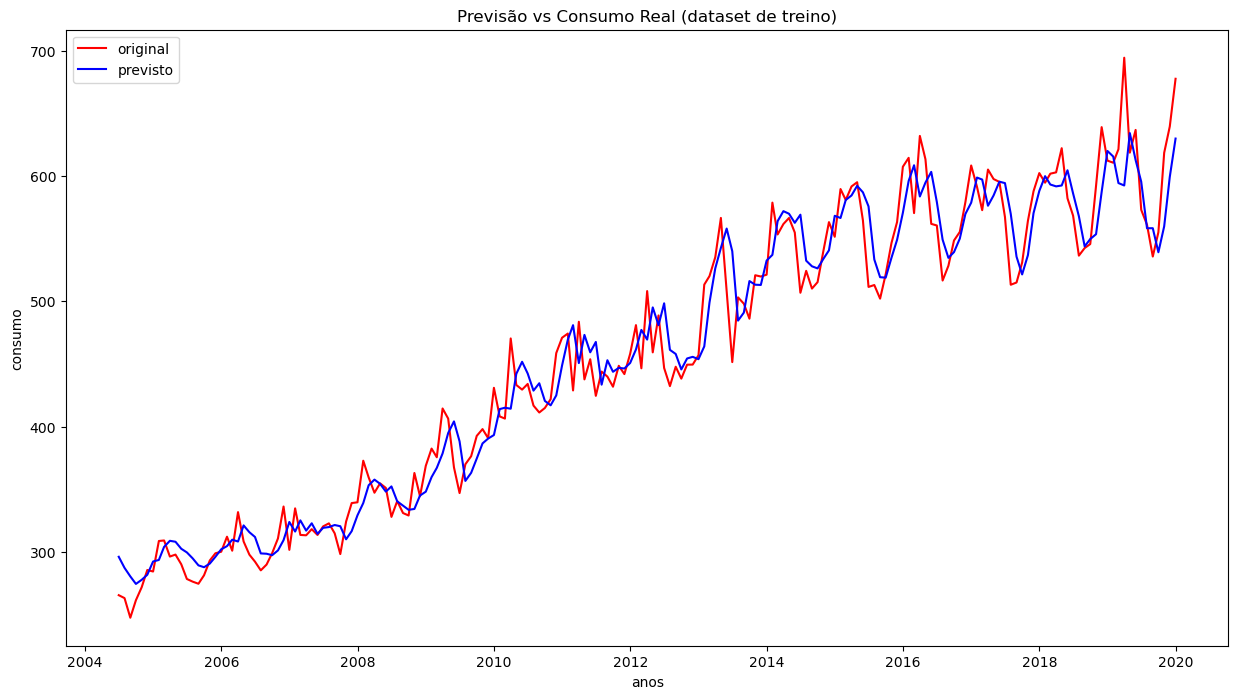

In [163]:
plt.figure(figsize=(15, 8))
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(treino_previsao_inv)], y_train_inv, label="original", color="red")
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(treino_previsao_inv)], treino_previsao_inv, label="previsto", color="blue")
plt.title("Previsão vs Consumo Real (dataset de treino)")
plt.xlabel("anos")
plt.ylabel("consumo")
plt.legend()
plt.show()

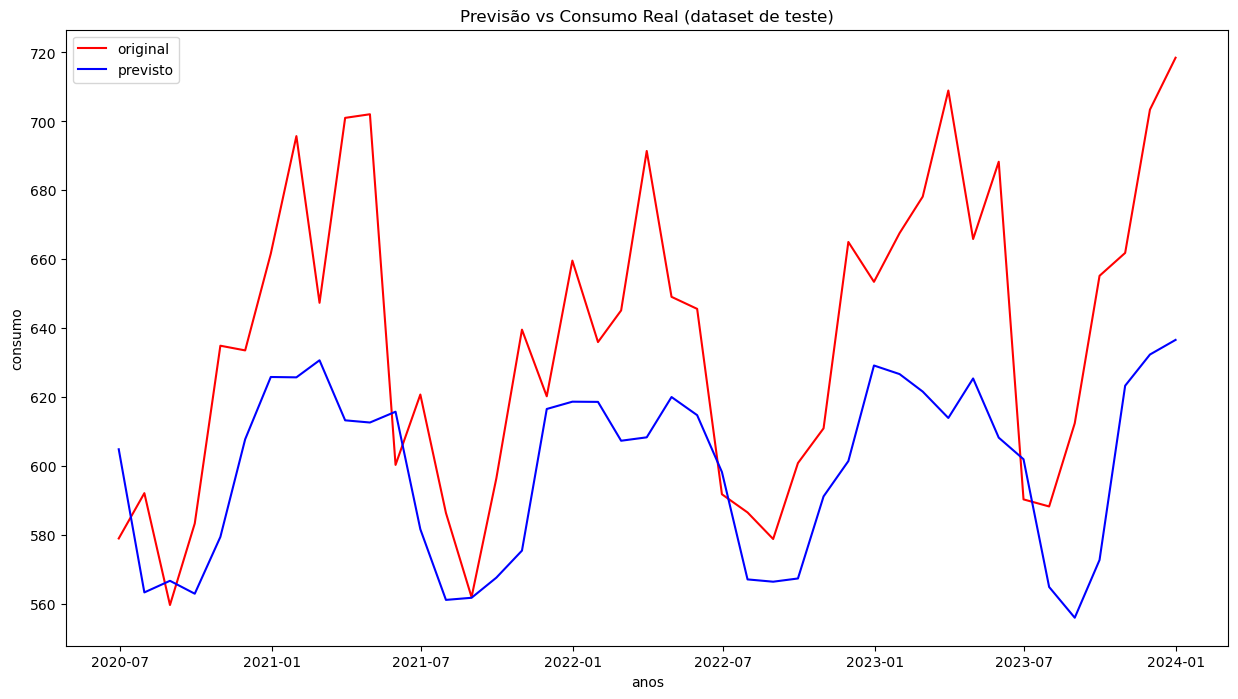

In [204]:
plt.figure(figsize=(15, 8))
plt.plot(teste_df.index[TIME_STEPS:TIME_STEPS+len(teste_previsao_inv)], y_test_inv, label="original", color="red")
plt.plot(teste_df.index[TIME_STEPS:TIME_STEPS+len(teste_previsao_inv)], teste_previsao_inv, label="previsto", color="blue")
plt.title("Previsão vs Consumo Real (dataset de teste)")
plt.xlabel("anos")
plt.ylabel("consumo")
plt.legend()
plt.show()